# Hand Gesture Recognition Using CNN

In [1]:
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_preprocessing
import numpy as np
import csv
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

%matplotlib inline

## Getting the dataset from Kaggle

Download the zip file from Kaggle: https://www.kaggle.com/datamunge/sign-language-mnist

## Unzipping and path settings

In [2]:
local_zip = '/tmp/sign-language-mnist.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/sign-language-mnist/')
zip_ref.close()

In [3]:
def get_data(filename):
    with open(filename) as training_file:
        csv_reader = csv.reader(training_file, delimiter=',')
        first_line = True
        temp_images = []
        temp_labels = []
        for row in csv_reader:
            if first_line:
                # print("Ignoring first line")
                first_line = False
            else:
                temp_labels.append(row[0])
                image_data = row[1:785]
                image_data_as_array = np.array_split(image_data, 28)
                temp_images.append(image_data_as_array)
        images = np.array(temp_images).astype('float')
        labels = np.array(temp_labels).astype('float')
    return images, labels

In [4]:
train_path = os.path.join('/tmp/sign-language-mnist/sign_mnist_train.csv')
test_path = os.path.join('/tmp/sign-language-mnist/sign_mnist_test.csv')

training_images, training_labels = get_data(train_path)
testing_images, testing_labels = get_data(test_path)

print(training_images.shape)
print(training_labels.shape)
print(testing_images.shape)
print(testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [5]:
training_images = np.expand_dims(training_images, axis=3)
testing_images = np.expand_dims(testing_images, axis=3)

## Data preprocessing

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    rescale=1. / 255)

print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7172, 28, 28, 1)


## Creating the CNN model

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(26, activation=tf.nn.softmax)
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               204928    
_________________________________________________________________
dense_1 (Dense)              (None, 26)                3

In [9]:
# Model configuration
model.compile(optimizer = tf.train.AdamOptimizer(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training and evaluation

In [10]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [11]:
with tf.device('/device:GPU:0'):
    history = model.fit_generator(train_datagen.flow(training_images, training_labels, batch_size=32),
                                  steps_per_epoch=len(training_images) / 32,
                                  epochs=15,
                                  validation_data=validation_datagen.flow(testing_images, testing_labels, batch_size=32),
                                  validation_steps=len(testing_images) / 32)

    model.evaluate(testing_images, testing_labels)

Epoch 1/15
858/857 [==============================] - 28s 33ms/step - loss: 2.8394 - acc: 0.1399 - val_loss: 2.1897 - val_acc: 0.3137
Epoch 2/15
858/857 [==============================] - 28s 33ms/step - loss: 2.1149 - acc: 0.3340 - val_loss: 1.4128 - val_acc: 0.5485
Epoch 3/15
858/857 [==============================] - 25s 29ms/step - loss: 1.7711 - acc: 0.4374 - val_loss: 1.1417 - val_acc: 0.5818
Epoch 4/15
858/857 [==============================] - 25s 29ms/step - loss: 1.5375 - acc: 0.5054 - val_loss: 0.9053 - val_acc: 0.6822
Epoch 5/15
858/857 [==============================] - 24s 28ms/step - loss: 1.3574 - acc: 0.5546 - val_loss: 0.7798 - val_acc: 0.7296
Epoch 6/15
858/857 [==============================] - 25s 29ms/step - loss: 1.2224 - acc: 0.6024 - val_loss: 0.6796 - val_acc: 0.7832
Epoch 7/15
858/857 [==============================] - 25s 29ms/step - loss: 1.1205 - acc: 0.6328 - val_loss: 0.7047 - val_acc: 0.7475
Epoch 8/15
858/857 [==============================] - 25s 29ms

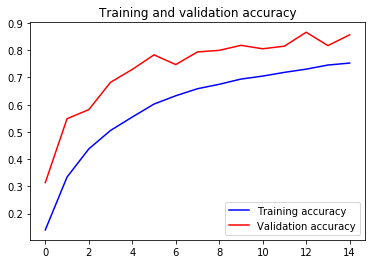

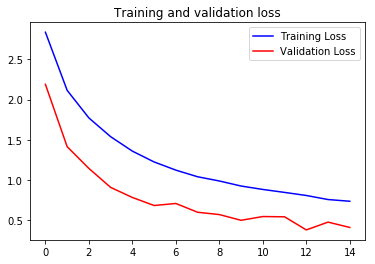

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()